# LSTM Model to detect Heel Strike and Toe-off events

In this notebook, we will predict whether each sample is a heel strike or toe-off based on the accelerometer data. To do so, we train an LSTM (Long-Short Term Memory) model on 70% of the data and test it on the remaining 30%

The LSTM architecture has
- a lookback window of 3 timesteps
- 6 features (X,Y,Z acceleration of left foot and right foot) 
- 44 hidden nodes

The first step to select the Subject Id, activity and event of interest

The subsequent steps to tune and test the model are as follows:

1. Subset the data based on subject, activity, and event
2. Remove noise from the data
3. Re-scale each of the features to range (0,5)
4. Split the data into training and testing sets  
5. Since we are using an LSTM architecture, we will implement a look-back function that will introduce historical data determined by the window size
6. Build and compile the Neural Network
7. Fit the model
8. Save the predictions and actual value to evaluate the model. The model is evaluated in terms of 
    - F1 score
    - Percentage of true positives
    - Mean of the absolute difference in time between true positives and corresponding GT events

# Note: before you run the code

You can adjust the subject Id, activity and event in the next cell.
Some parts are specific to indoors/outdoors, so you will need to comment the part if needed, and uncomment it it's if not needed.

In [482]:
import pandas as pd

## 1. Subset the data based on subject, activity and event


In [483]:
####### Select Subject Id #######
# Key in a number from 1 to 20. 

# 1 to 11: indoors
# 12 to 20: outdoors

SUBJECT_ID = '18'

###### Select Activity ######
# Key in one of the options below:

## For indoors: 
# treadmill_walk
# treadmill_run
# treadmill_walknrun
# treadmill_all (treadmill_walk + treadmill_walknrun + treadmill_slope_walk)
# indoor_walk
# indoor_run
# indoor_walknrun

## For outdoors:
# outdoor_walk
# outdoor_run
# outdoor_walknrun

ACTIVITY = 'outdoor_run'


###### Select Event ######
# LF_HS
# LF_TO
# RF_HS
# RF_TO

EVENT = 'LF_TO'

In [484]:
# read in the data
DATA_PATH = './Combined Data_csv format/'

df = pd.read_csv(DATA_PATH + 'Sub_'+ SUBJECT_ID + '.csv', header = 0)

In [485]:
df = df.drop(df.columns[0], axis=1)
df.head()

,accX_LF,accY_LF,accZ_LF,accX_RF,accY_RF,accZ_RF,accX_Waist,accY_Waist,accZ_Waist,accX_Wrist,accY_Wrist,accZ_Wrist,outdoor_walk,outdoor_walk_index,outdoor_walknrun,outdoor_walknrun_index,LF_HS,RF_HS,LF_TO,RF_TO
0,-2.510,-9.882,-2.353,9.412,-19.608,-11.137,-0.471,-9.255,0.157,1.569,-8.784,2.510,1,1,1,1,0.0,0.0,0.0,0.0
1,-2.353,-10.039,-2.353,9.725,-18.824,-11.608,-0.471,-9.412,0.157,1.569,-8.627,2.980,1,2,1,2,0.0,0.0,0.0,0.0
2,-2.039,-10.196,-2.196,10.510,-18.667,-13.176,-0.627,-9.725,0.157,1.569,-8.157,2.824,1,3,1,3,0.0,0.0,0.0,0.0
3,-1.725,-10.039,-2.039,12.392,-18.510,-13.490,-0.784,-10.196,0.314,1.569,-8.157,3.137,1,4,1,4,0.0,0.0,0.0,0.0
4,-1.412,-10.039,-1.882,14.902,-17.098,-15.373,-0.941,-10.824,0.471,1.569,-7.686,3.451,1,5,1,5,0.0,0.0,0.0,0.0


Since there is no indicator variable for treadmill_all for subjects 1-11, let's create another column for this. The value of this data is 1 if either treadmill_walknrun is 1 or treadmill_slope_walk is 1

In [486]:
###############################################
######## Specific to indoors only #############
###############################################

# for SUBJECT_ID 1 to 11, uncomment if otherwise

def label_treadmill_all (row):
   if row['treadmill_walknrun'] == 1:
      return 1
   if row['treadmill_slope_walk'] == 1:
      return 1
   return 0

df['treadmill_all']=df.apply (lambda row: label_treadmill_all(row),axis=1)

def label_indoor_run (row):
   if row['indoor_walknrun'] == 1 and row['indoor_walk'] == 0:
      return 1
   return 0

df['indoor_run']=df.apply (lambda row: label_indoor_run(row),axis=1)

def label_treadmill_run (row):
   if row['treadmill_walknrun'] == 1 and row['treadmill_walk'] == 0:
      return 1
   return 0

df['treadmill_run']=df.apply (lambda row: label_indoor_run(row),axis=1)


df.head()

# ###############################################
# ######## Specific to outdoors only ############
# ###############################################

# # for SUBJECT_ID 12 to 20, uncomment if otherwise

# def label_outdoor_run (row):
#    if row['outdoor_walknrun'] == 1 and row['outdoor_walk'] == 0:
#       return 1
#    return 0

# df['outdoor_run']=df.apply (lambda row: label_outdoor_run(row),axis=1)

# df.head()

,accX_LF,accY_LF,accZ_LF,accX_RF,accY_RF,accZ_RF,accX_Waist,accY_Waist,accZ_Waist,accX_Wrist,...,accZ_Wrist,outdoor_walk,outdoor_walk_index,outdoor_walknrun,outdoor_walknrun_index,LF_HS,RF_HS,LF_TO,RF_TO,outdoor_run
0,-2.510,-9.882,-2.353,9.412,-19.608,-11.137,-0.471,-9.255,0.157,1.569,...,2.510,1,1,1,1,0.0,0.0,0.0,0.0,0
1,-2.353,-10.039,-2.353,9.725,-18.824,-11.608,-0.471,-9.412,0.157,1.569,...,2.980,1,2,1,2,0.0,0.0,0.0,0.0,0
2,-2.039,-10.196,-2.196,10.510,-18.667,-13.176,-0.627,-9.725,0.157,1.569,...,2.824,1,3,1,3,0.0,0.0,0.0,0.0,0
3,-1.725,-10.039,-2.039,12.392,-18.510,-13.490,-0.784,-10.196,0.314,1.569,...,3.137,1,4,1,4,0.0,0.0,0.0,0.0,0
4,-1.412,-10.039,-1.882,14.902,-17.098,-15.373,-0.941,-10.824,0.471,1.569,...,3.451,1,5,1,5,0.0,0.0,0.0,0.0,0


In [487]:
# Subset out the data by activity of interest

k1=df[df[ACTIVITY]==1]
k1.head()

,accX_LF,accY_LF,accZ_LF,accX_RF,accY_RF,accZ_RF,accX_Waist,accY_Waist,accZ_Waist,accX_Wrist,...,accZ_Wrist,outdoor_walk,outdoor_walk_index,outdoor_walknrun,outdoor_walknrun_index,LF_HS,RF_HS,LF_TO,RF_TO,outdoor_run
23801,-12.549,-1.725,1.255,-7.686,-20.706,1.098,2.039,-11.922,-0.314,2.353,...,5.804,0,0,1,23802,0.0,0.0,0.0,0.0,1
23802,0.784,-4.235,-0.471,-5.490,-18.039,0.471,1.725,-12.235,2.667,3.137,...,5.804,0,0,1,23803,0.0,0.0,0.0,0.0,1
23803,-6.118,-11.608,-1.725,-0.784,-12.863,-1.098,0.000,-12.078,9.725,3.294,...,5.804,0,0,1,23804,0.0,0.0,0.0,0.0,1
23804,-8.157,-7.373,-1.255,-0.784,-14.118,-0.157,-0.314,-12.235,10.667,3.608,...,5.961,0,0,1,23805,0.0,0.0,0.0,0.0,1
23805,-5.333,-9.569,-0.471,1.569,-16.471,-4.549,0.314,-11.922,9.725,4.078,...,6.431,0,0,1,23806,0.0,0.0,0.0,0.0,1


In [488]:
# Select the columns you want -- the first few accelerometer data and event of interest
k2 = k1[['accX_LF','accY_LF','accZ_LF','accX_RF','accY_RF','accZ_RF', EVENT]]
k2.head()

,accX_LF,accY_LF,accZ_LF,accX_RF,accY_RF,accZ_RF,LF_TO
23801,-12.549,-1.725,1.255,-7.686,-20.706,1.098,0.0
23802,0.784,-4.235,-0.471,-5.490,-18.039,0.471,0.0
23803,-6.118,-11.608,-1.725,-0.784,-12.863,-1.098,0.0
23804,-8.157,-7.373,-1.255,-0.784,-14.118,-0.157,0.0
23805,-5.333,-9.569,-0.471,1.569,-16.471,-4.549,0.0


## 2. Remove noise from the data

In [489]:
k2['accX_LF_median']=k2['accX_LF'].rolling(window=3).mean()
k2['accY_LF_median']=k2['accY_LF'].rolling(window=3).mean()
k2['accZ_LF_median']=k2['accZ_LF'].rolling(window=3).mean()

k2['accX_RF_median']=k2['accX_RF'].rolling(window=3).mean()
k2['accY_RF_median']=k2['accY_RF'].rolling(window=3).mean()
k2['accZ_RF_median']=k2['accZ_RF'].rolling(window=3).mean()

k2[:10]

/Users/tankh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/tankh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/tankh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

,accX_LF,accY_LF,accZ_LF,accX_RF,accY_RF,accZ_RF,LF_TO,accX_LF_median,accY_LF_median,accZ_LF_median,accX_RF_median,accY_RF_median,accZ_RF_median
23801,-12.549,-1.725,1.255,-7.686,-20.706,1.098,0.0,NaN,NaN,NaN,NaN,NaN,NaN
23802,0.784,-4.235,-0.471,-5.490,-18.039,0.471,0.0,NaN,NaN,NaN,NaN,NaN,NaN
23803,-6.118,-11.608,-1.725,-0.784,-12.863,-1.098,0.0,-5.961000,-5.856000,-0.313667,-4.653333,-17.202667,0.157000
23804,-8.157,-7.373,-1.255,-0.784,-14.118,-0.157,0.0,-4.497000,-7.738667,-1.150333,-2.352667,-15.006667,-0.261333
23805,-5.333,-9.569,-0.471,1.569,-16.471,-4.549,0.0,-6.536000,-9.516667,-1.150333,0.000333,-14.484000,-1.934667
23806,-3.451,-10.039,-0.471,1.412,-17.882,-5.647,0.0,-5.647000,-8.993667,-0.732333,0.732333,-16.157000,-3.451000
23807,-1.725,-10.667,-0.314,-0.784,-10.510,-9.569,0.0,-3.503000,-10.091667,-0.418667,0.732333,-14.954333,-6.588333
23808,-0.784,-11.137,-0.784,-0.314,-4.863,-8.627,0.0,-1.986667,-10.614333,-0.523000,0.104667,-11.085000,-7.947667
23809,-0.157,-11.294,-2.824,-2.510,-8.000,-8.157,0.0,-0.888667,-11.032667,-1.307333,-1.202667,-7.791000,-8.784333
23810,-1.098,-10.353,-3.137,-3.608,-13.804,2.196,0.0,-0.679667,-10.928000,-2.248333,-2.144000,-8.889000,-4.862667


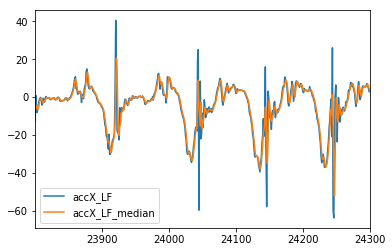

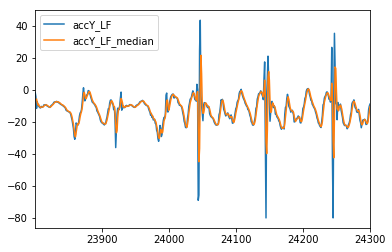

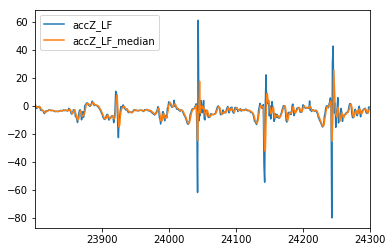

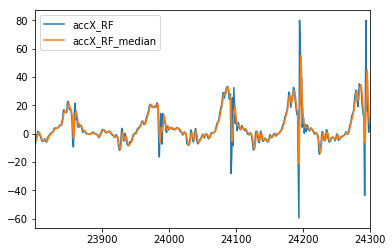

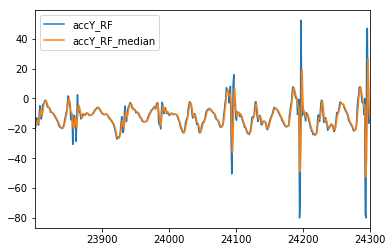

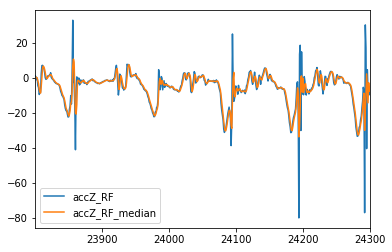

In [490]:
# Visualise
k2[['accX_LF','accX_LF_median']][:500].plot()
k2[['accY_LF','accY_LF_median']][:500].plot()
k2[['accZ_LF','accZ_LF_median']][:500].plot()

k2[['accX_RF','accX_RF_median']][:500].plot()
k2[['accY_RF','accY_RF_median']][:500].plot()
k2[['accZ_RF','accZ_RF_median']][:500].plot()

In [491]:
# Select the columns you want -- the rolling median accelerometer data and event of interest
# Remove the first two rows which have no accelerometer data
k3 = k2[['accX_LF_median','accY_LF_median','accZ_LF_median','accX_RF_median','accY_RF_median','accZ_RF_median', EVENT]]
k3 = k3.iloc[2:]
k3.head()

,accX_LF_median,accY_LF_median,accZ_LF_median,accX_RF_median,accY_RF_median,accZ_RF_median,LF_TO
23805,-6.536000,-9.516667,-1.150333,0.000333,-14.484000,-1.934667,0.0
23806,-5.647000,-8.993667,-0.732333,0.732333,-16.157000,-3.451000,0.0
23807,-3.503000,-10.091667,-0.418667,0.732333,-14.954333,-6.588333,0.0
23808,-1.986667,-10.614333,-0.523000,0.104667,-11.085000,-7.947667,0.0
23809,-0.888667,-11.032667,-1.307333,-1.202667,-7.791000,-8.784333,0.0


## 3. Re-scale each of the features to range (0,5)

"LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. It can be a good practice to rescale the data, also called normalizing. We can easily normalize the dataset using the MinMaxScaler preprocessing class from the scikit-learn library."

In [492]:
dataset = k3.values

from sklearn.preprocessing import MinMaxScaler

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 5))
dataset = scaler.fit_transform(dataset)

## 4. Split the data into training and test sets


In [493]:
# split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

17497 7499


In [494]:
print(train)

[[2.9850764  2.32999428 2.81471868 ... 2.17179562 3.31041541 0.        ]
 [3.02472697 2.3484761  2.83044301 ... 2.098106   3.24611422 0.        ]
 [3.12035217 2.30967487 2.84224254 ... 2.15107914 3.1130734  0.        ]
 ...
 [1.44356596 2.66815636 2.89143438 ... 1.76416092 3.48559337 0.        ]
 [1.69309542 2.69586144 2.85209846 ... 1.81482895 3.57429197 0.        ]
 [1.95661482 2.68846399 2.84226761 ... 1.8516811  3.63637392 0.        ]]


## 5. Implement a look-back function that will introduce historical data determined by the window size

Now we can define a function to create a new dataset, as described above.
The function takes two arguments: the dataset, which is a NumPy array that we want to convert into a dataset, and the look_back, which is the number of previous time steps to use as input variables to predict the next time period — in this case defaulted to 1


In [495]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0:6]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 6])
	return numpy.array(dataX), numpy.array(dataY)

In [496]:
import numpy

look_back=3 # 3 timesteps
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [497]:
trainX[0:5]

array([[[2.9850764 , 2.32999428, 2.81471868, 2.09298803, 2.17179562,
         3.31041541],
        [3.02472697, 2.3484761 , 2.83044301, 2.1219126 , 2.098106  ,
         3.24611422],
        [3.12035217, 2.30967487, 2.84224254, 2.1219126 , 2.15107914,
         3.1130734 ]],

       [[3.02472697, 2.3484761 , 2.83044301, 2.1219126 , 2.098106  ,
         3.24611422],
        [3.12035217, 2.30967487, 2.84224254, 2.1219126 , 2.15107914,
         3.1130734 ],
        [3.18798262, 2.29120482, 2.83831772, 2.0971107 , 2.32150932,
         3.05542991]],

       [[3.12035217, 2.30967487, 2.84224254, 2.1219126 , 2.15107914,
         3.1130734 ],
        [3.18798262, 2.29120482, 2.83831772, 2.0971107 , 2.32150932,
         3.05542991],
        [3.23695486, 2.27642171, 2.80881265, 2.04545215, 2.46659815,
         3.01995047]],

       [[3.18798262, 2.29120482, 2.83831772, 2.0971107 , 2.32150932,
         3.05542991],
        [3.23695486, 2.27642171, 2.80881265, 2.04545215, 2.46659815,
         3.0199

In [498]:
trainY[0:5]

array([0., 0., 0., 0., 0.])

## 6. Build and compile the Neural Network

input to be [samples, time steps, features]

In [499]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

In [500]:
model = Sequential()

# Recurrent layer
model.add(LSTM(44, return_sequences=False, dropout=0.1, recurrent_dropout=0.1))

# Fully connected layer
model.add(Dense(44, activation='relu'))

# Dropout for regularization
model.add(Dropout(0.5))

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## 7. Fit the model

Further split the training dataset into 2/3 train and 1/3 validation.
Epoch size is 20
Batch size is 20

In [501]:
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping

es= EarlyStopping(monitor='val_loss', min_delta=0,patience=5,verbose=0, mode='auto')

# Fit the model
history = model.fit(trainX, trainY, validation_split = 0.33, epochs=50, batch_size=20, verbose=0, callbacks=[TQDMNotebookCallback(),es])

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


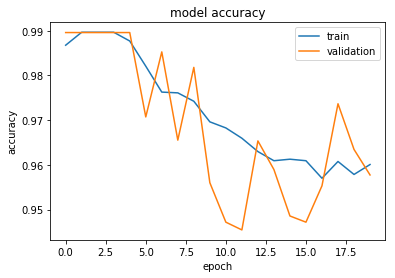

In [502]:
from matplotlib import pyplot as plt

# List all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'])
plt.show()

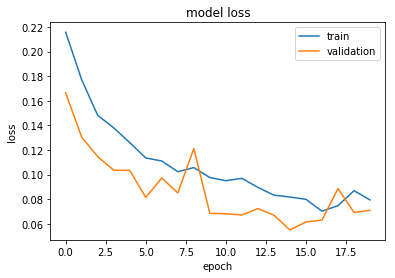

In [503]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'])
plt.show()

In [504]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 44)                8976      
_________________________________________________________________
dense_33 (Dense)             (None, 44)                1980      
_________________________________________________________________
dropout_17 (Dropout)         (None, 44)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 45        
Total params: 11,001
Trainable params: 11,001
Non-trainable params: 0
_________________________________________________________________


## 8. Save the predictions and actual value to evaluate the model

The predictions are floating point values and we recode them as 1 if greater than 0.5 and 0 otherwise.

In [505]:
testY_predict = model.predict(testX)

In [506]:
print(testY_predict)

[[6.5232511e-05]
 [6.0161707e-05]
 [7.1859991e-05]
 ...
 [2.1765872e-03]
 [3.1838636e-03]
 [2.4791840e-03]]


In [507]:
print(len(testY), len(testY_predict))

7495 7495


In [508]:
predicted = []
actual = []
for i in range(len(testY)):
    #print(int(testY_predict[i]>0.5), int(testY[i]>0.5))
    predicted.append(int(testY_predict[i]>0.5))
    actual.append(int(testY[i]>0.5))

In [509]:
PREDICTIONS_DF = pd.DataFrame(list(zip(predicted, actual)),
  columns=['predicted','actual'])

In [510]:
PREDICTIONS_DF.head()

,predicted,actual
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [511]:
# write dataframe to .csv
SAVE_PATH = './Predicted Data_model_csv format/'
PREDICTIONS_DF.to_csv(SAVE_PATH+'Sub'+SUBJECT_ID+'_'+ ACTIVITY + '_'+ EVENT + '.csv', encoding='utf-8')